In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Mapping

The art of creating maps given laserscans and the poses.

First let's load a dataset with which we can play around.

In [3]:
from slamlib.dataset import Dataset
from slamlib.rangefinder import Laserscanner, Scan
from slamlib.pose import Pose

dataset = Dataset()
dataset.load("slam_dataset.npz")

Now use the slamlib mapping package to create a density grid map.
This is a helper class which can insert laserscans into an existing map.

In [4]:
from slamlib.mapping import DensityGridMap

map_size = 50
map_scale = 0.1
map_positive_scan_weight = 0.001
gridMap = DensityGridMap(int(map_size / map_scale),
                         Pose(map_size/2, map_size/2, 0),
                         scale=map_scale,
                         positive_scan_weight=map_positive_scan_weight)

Let me explain how the density grid map is implemented before we use it.

It has a method add_density(x, y, modificator), which implements modifying the density at a given position in meters and convert it into the map scale.

```python
    def add_density(self, x, y, modificator):
        tx = x + self.offset_pose.x
        ty = y + self.offset_pose.y
        ix = int(tx / self.scale)
        iy = int(ty / self.scale)

        if ix < 0 or ix >= self.size
            or iy < 0 or iy >= self.size:
            return False

        val = modificator + self.map[ix, iy]
        self.map[ix, iy] = max(min(val, self.max_value),
                               self.min_value)
```

This can then be used in an insert scan method to insert a scan at a given position

```python
    def insert_scan_only_endpoint(self, scan, robot_pose):
        rays = scan.get_rays(robot_pose)

        for ray in rays:
            pose, dist = ray

            end_pose = pose.add_relative_pose(Pose(dist, 0, 0))
            self.add_density(end_pose.x, end_pose.y,
                             self.positive_scan_weight)
```

Now that you understood the two methods. Let's use them to plot a map from our dataset. By using the playback as in the 'Handling a Dataset' notebook. But instead of printing the stuff, saving the pose and inserting the scan endpoints into the map.

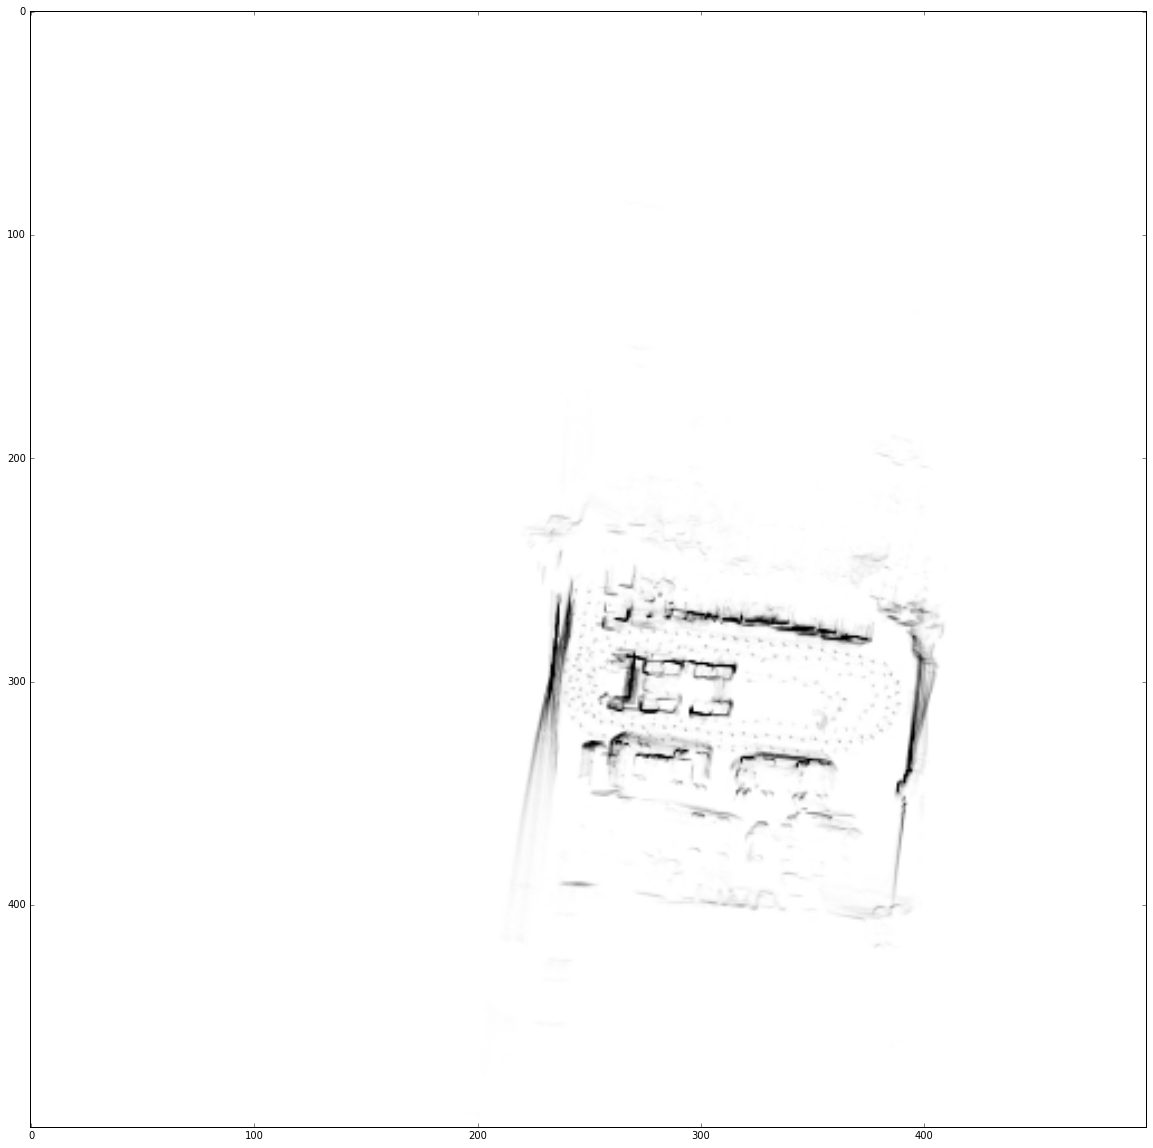

In [ ]:
from slamlib.dataset import Playback
import time
import pylab as pl
from IPython import display

current_pose = None
trajectory = []

def on_scan(scan):
    if current_pose is None:
        return
    trajectory.append(current_pose)
    gridMap.insert_scan_only_endpoint(scan, current_pose)
    
def on_pose(data):
    global current_pose
    time, pose = data
    current_pose = pose
    
playback = Playback(dataset, on_scan, on_pose)
gridMap.reset_map()

err = False
iteration = 0
while playback.tick():
    iteration += 1
    if iteration % 100 == 0:
        pl.set_cmap('gray_r')
        pl.rcParams['figure.figsize'] = (20, 20)
        pl.imshow(gridMap.map)
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(0.01)

Ok no error, let's plot the results.

To be honest, I did not expect it to look that bad...
Ok let's see the trajectory that the robot was driving.

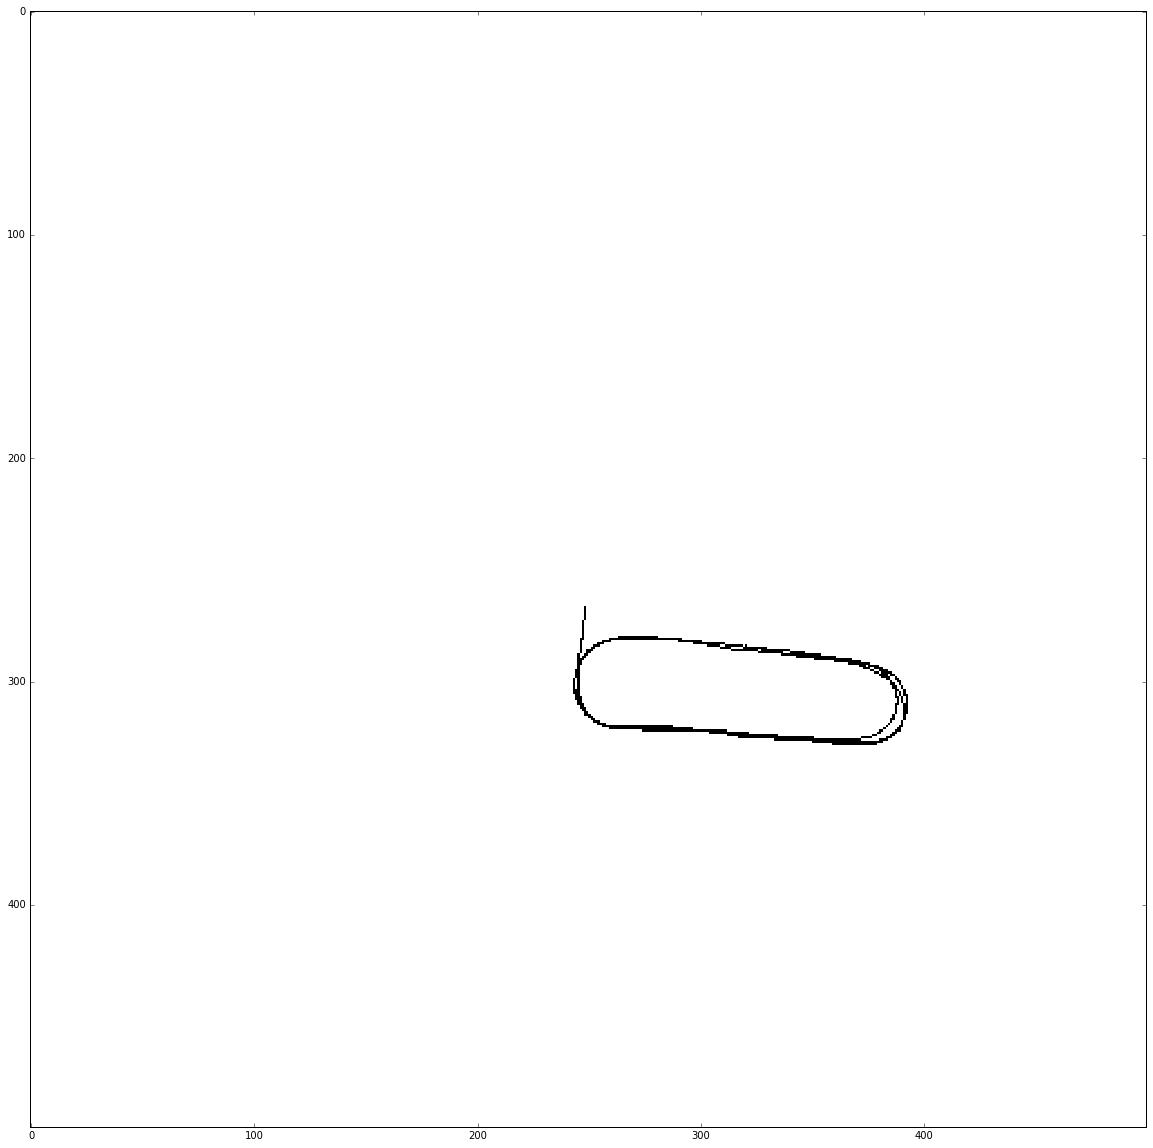

In [8]:
imap_size = int(map_size/map_scale)
trajectory_render = np.zeros((imap_size, imap_size))

for pose in trajectory:
    tx = pose.x + map_size/2
    ty = pose.y + map_size/2
    ix = int(tx / map_scale)
    iy = int(ty / map_scale)

    if ix < 0 or ix >= imap_size or iy < 0 or iy >= imap_size:
        continue

    trajectory_render[ix, iy] = 1
    
plt.set_cmap('gray_r')
plt.rcParams['figure.figsize'] = (20, 20)
plt.imshow(trajectory_render, interpolation="nearest")